# Offline reconstruction of pMRI data

In this notebook we study offline reconstruction algorithm for pMRI data.
Dependecies:
- this repository
- pysap-mri
- pysap
- modopt
and their dependencies
## Introduction

Typically, MRI reconstruction is done entirely after the full acquisition of the k-space data (so-called offline reconstruction)
During the acquisition sequence of MRI can be very long, and this dead time can be used to start the reconstruction.
### Offline vs Online

In the context of pMRI the problem is stated as follows for an (calibrationless) offline reconstruction
$$
\hat{x} = \arg\min \|\Omega \mathcal{F}x - y \| + g(\Psi x) \tag{Problem 1}
$$

where:
- $\mathcal{F}$ is the fourier transform operator
- $\Omega$ is the sampling mask, representing the acquisition by the MRI
- $y$ is the completly observed data in kspace.
- $\Psi$ is a sparsifying transform (typically a Wavelet transform)
- $g$ is a proximable regularisation operator ($\ell_1$, groupLasso, OWL...)

Solving this problem is done by using an iterative algorithm relying on convex Optimisation and gradient descent (Condat-Vu, POGM, FISTA...)


## Setup

- This notebook relies on the python packages modopt, pysap, pysap-mri and their dependences.
- As a toy model, let's consider a 2D pMRI acquisition with 16 channels where the k-space ( of size 640 x 320) is sampled along 80 columns.

In [3]:
%cd /home/pac/gits/phd/mri-online/

/home/pac/gits/phd/mri-online


In [4]:
import os
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy as sp
from mri.operators import FFT, WaveletN, OWL
from modopt.opt.proximity import GroupLASSO
from mri.reconstructors import CalibrationlessReconstructor
from mri.operators import GradAnalysis, GradSynthesis

from project_utils import implot, load_data
from online.metrics import psnr_ssos, ssim_ssos, ssos

In [5]:
DATA_DIR = "data/"
RESULT_DIR = "data/results/"
N_JOBS = 1
results = dict()

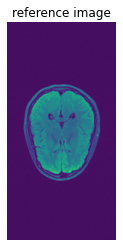

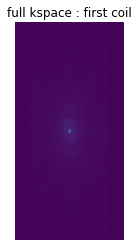

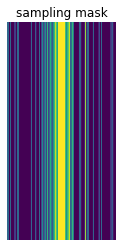

In [7]:
full_k, real_img, mask_loc, final_mask = load_data(DATA_DIR,1)
# use mono-coil data
full_k = sp.fft.fftshift(sp.fft.fft2(real_img,norm="ortho"))
final_k = full_k * final_mask

implot(real_img, "reference image")
implot(np.sqrt(np.abs(full_k)), "full kspace : first coil")
implot(final_mask, "sampling mask")

K_DIM = final_mask.shape
N_COILS = 1

## naive direct inversion

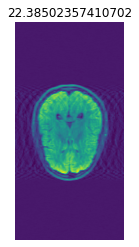

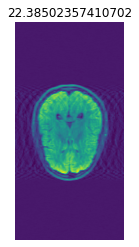

In [8]:
dirrec= sp.fft.ifft2(sp.fft.ifftshift(final_k))
implot(dirrec, title=f'{psnr_ssos(dirrec,real_img)}')

## Condat + GL

In [9]:
fourier_op = FFT(mask=final_mask,
                 shape=K_DIM,
                 n_coils=N_COILS,
                 n_jobs=N_JOBS)

# Wavelets coefficients for each coils
linear_op = WaveletN("sym8", nb_scale=4, n_coils=N_COILS, n_jobs=N_JOBS)
# initialisation of wavelet transform
linear_op.op(np.zeros_like(final_k))

# Regularizer definition
GL_op = GroupLASSO(weights=1e-3)
OWL_op = OWL(alpha=1e-05,
             beta=1e-12,
             bands_shape=linear_op.coeffs_shape,
             mode='band_based',
             n_coils=N_COILS,
             n_jobs=N_JOBS)


prox_op = GL_op
cost_op_kwargs={'cost_interval':1}
solver = CalibrationlessReconstructor(
        fourier_op,
        linear_op=linear_op,
        regularizer_op=prox_op,
        gradient_formulation="analysis",
        verbose=0)

metrics = {'psnr': {'metric': lambda test, ref: psnr_ssos(test,ref),
                        'mapping': {'x_new': 'test'},
                        'early_stopping': False,
                        'cst_kwargs': {'ref': real_img},
                        }}
xf_condat, cost, metric_results_condatvu= solver.reconstruct(final_k,
                                                             optimization_alg='condatvu',
                                                             metrics=metrics,
                                                             metric_call_period=1,
                                                        )


metric_results_condatvu['cost'] = {'index':np.arange(0,len(cost),cost_op_kwargs['cost_interval']),
                          'values':np.array(cost)}


100% (100 of 100) |######################| Elapsed Time: 0:00:14 Time:  0:00:14


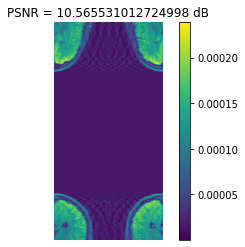

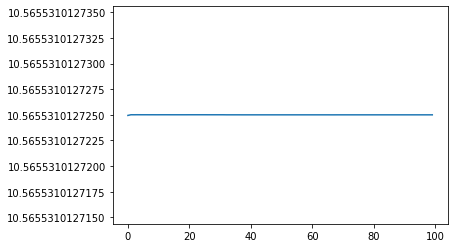

In [10]:
psnr = psnr_ssos(xf_condat,real_img)
implot(ssos(xf_condat),title=f"PSNR = {psnr} dB", colorbar=True)
fig,ax = plt.subplots()
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.plot(metric_results_condatvu['psnr']['index'],metric_results_condatvu['psnr']['values'])


### POGM + GL


In [ ]:
prox_op=GL_op
# The fourier Operator apply also the sampling mask.
cost_op_kwargs={'cost_interval':1}
solver2 = CalibrationlessReconstructor(
        fourier_op,
        linear_op=linear_op,
        regularizer_op=prox_op,
        gradient_formulation="synthesis",
        verbose=0)

xf_pogm, cost, metric_results_pogm = solver2.reconstruct(final_k, optimization_alg='pogm')

metric_results_pogm['cost'] = {'index':np.arange(0,len(cost),cost_op_kwargs['cost_interval']),
                          'values':np.array(cost)}

results['pogm'] = {
    'xf': xf_pogm,
    'metrics': metric_results_pogm
}

In [ ]:
psnr = psnr_ssos(xf_condat,real_img)
implot(ssos(xf_pogm), title=f"PSNR = {psnr} dB", colorbar=True)
